In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation as am


Bad key "text.kerning_factor" on line 4 in
/Users/yutingli/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [7]:

label = 'h_0.4_p_0.8_q_0.1'
file = open("data_{}.txt".format(label))

realisations = []
moments = [] 
realisation_flag = False 
moments_flag = False
L = 257

n = 0 

line = file.readline() 
while line: 
    if line[0] == '#':
        print(line)
        if line.startswith('# Starting'):
            realisation_flag = True 
        if line.startswith('#Writing'): 
            moments_flag = True 
    else: 
        if moments_flag: 
            moments.append(line)
        elif realisation_flag: 
            new_realisation = [line]
            realisations.append(new_realisation)
            realisation_flag = False
        else:
            new_realisation.append(line)   
    line = file.readline()

#Parameters={ Seed: 5, Branching rate: 0.4, p : 0.8, q : 0.1, Realisations: 10, Chunk size: 10, Dimension: 2, (Max) Lattice size: 257, Graph Type: 0 }

#Version: #f883

# Running for L = 257

# Starting the 0 th realisation 

# Starting the 1 th realisation 

# Starting the 2 th realisation 

# Starting the 3 th realisation 

# Starting the 4 th realisation 

# Starting the 5 th realisation 

# Starting the 6 th realisation 

# Starting the 7 th realisation 

# Starting the 8 th realisation 

# Starting the 9 th realisation 

#Writing moments: 

# Info: count_full_resets=0 and count_cache_resets=10

#okely dokely!


In [8]:
def extract_lite(realisation): 
    total_active = [] 
    total_tracer = [] 
    tracer_snapshot = np.zeros((L, L)) 
    time = [] 
    flag = False 

    for line in realisation:  
        if line.startswith('time'):
            time.append(float(line[5:-1]))
        elif line.startswith('total active'):
            total_active.append(float(line[13:-1]))
        elif line.startswith('total tracer'):
            total_tracer.append(float(line[13:-1]))
        elif line.startswith('passive'):
            passive_indices = np.fromstring(line[8:-1], sep=',')
            passive_indices = np.unravel_index(passive_indices.astype('int'), (L, L))
        elif line.startswith('coarse_grain_tracer'):
            flag = True 
    
    tracer_snapshot[passive_indices] = 1 # set occupied sites to -1     
    return time, total_active, total_tracer, tracer_snapshot

def extract_moments(moments): 
    active_moments = [] 
    tracer_moments = [] 
    active_flag = False 
    tracer_flag = False 
    
    for line in moments: 
        if line.startswith(' active moments'):
            active_flag = True 
        elif line.startswith('tracer moments'):
            active_flag = False 
            tracer_flag = True 
        else: 
            if active_flag: 
                active_moments.append(np.fromstring(line, sep='\t'))
            if tracer_flag: 
                tracer_moments.append(np.fromstring(line, sep='\t'))
    return np.vstack(active_moments), np.vstack(tracer_moments)
        
def extract_evolution(realisation): 
    tracers = []
    active_particles = [] 
    edges = [] 
    msds = [] 
    total_active = [] 
    total_tracer = [] 
    time = [] 
    passive_flag = False 
    active_flag = False
    for line in realisation:  
        if line.startswith('time'):
            time.append(float(line[5:-1]))
        elif line.startswith('total active'):
            total_active.append(float(line[13:-1]))
        elif line.startswith('total tracer'):
            total_tracer.append(float(line[13:-1]))
        elif line.startswith('passive'):
            passive_indices = np.fromstring(line[8:-1], sep=',')
            passive_indices = np.unravel_index(passive_indices.astype('int'), (L, L))
            passive_flag = True 
        elif line.startswith('active'):
            active_indices = np.fromstring(line[7:-1], sep=',')
            active_indices = np.unravel_index(active_indices.astype('int'), (L, L))
            active_flag = True 
        elif line.startswith('msd'):
            msds.append(float(line[4:-1]))
        elif line.startswith('edge'): 
            edges.append(np.fromstring(line[5:-1], sep=','))
        else: 
            tracer_snapshot = np.zeros((L, L)) # clear the snapshot for the next time slice 
            active_snapshot = np.zeros((L, L)) 
            
        if passive_flag and active_flag: 
            tracer_snapshot[passive_indices] = 1 # set occupied sites to -1 
            
            for (i,j) in zip(*active_indices):
                active_snapshot[i, j] += 1 
            tracers.append(tracer_snapshot)
            active_particles.append(active_snapshot)
            passive_flag = False 
            active_flag = False 
            
    return np.array(edges), np.array(msds), np.array(counts), np.array(tracers), np.array(active_particles)

def make_movies(evolution, label):
    fig = plt.figure(figsize=(20, 20))
    ims = []
    plt.axis('off')
    for xy in evolution:
        im = plt.imshow(xy, animated=True, vmin=0, vmax=2, cmap='Blues', origin='lower') 
        plt.axis('off')
        ims.append([im])
        
    ani = am.ArtistAnimation(fig, ims, interval=100, blit=True,
                                    repeat_delay=1000)
    mywriter = am.FFMpegWriter()
    ani.save("{}_movie_{}.mp4".format(label, i), writer=mywriter)
    plt.close()  
    
    
def pad(nested_lists): 
    max_length = max(map(len, nested_lists))
    for l in nested_lists: 
        length = len(l)
        if length == 0: 
            raise Exception('no time series data recorded')
        elif length < max_length: 
            l.extend([l[-1]]*(max_length-length))
    return np.vstack(nested_lists)

def select_longest(times): 
    return max(times, key=lambda x:len(x))
    
    

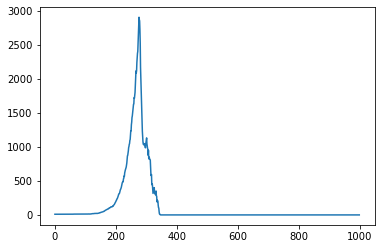

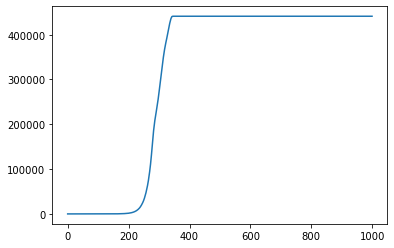

In [9]:
# print(moments)
active_moments, tracer_moments = extract_moments(moments)

plt.plot(active_moments[:, 2])
plt.show() 

plt.plot(tracer_moments[:, 2])
plt.show() 

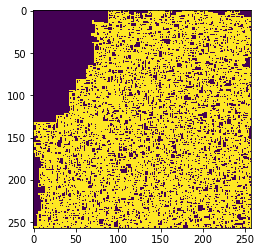

In [10]:
actives = [] 
tracers = [] 
tracer_snapshots = [] 
times = [] 
tracer_gdf = []

for (i, realisation) in enumerate(realisations):

    time, total_active, total_tracer, tracer_snapshot = extract_lite(realisation)
    times.append(time)
    actives.append(total_active)
    tracers.append(total_tracer)
    tracer_snapshots.append(tracer_snapshot)

plt.imshow(tracer_snapshots[1])